# Parsing WF Yogurt Data

In [34]:
import jsonlines
import numpy as np
import pandas as pd
import re

### Extract from scraped WF data

In [35]:
# convert jsonl to dataframe
jpath = "./yogurts_wf/wf-yog-3.jsonl"

with jsonlines.open(jpath) as reader:
    df = pd.DataFrame(reader)
    df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   link               232 non-null    object
 1   name               232 non-null    object
 2   brand              232 non-null    object
 3   diets              232 non-null    object
 4   categories         232 non-null    object
 5   images             232 non-null    object
 6   ingredients        232 non-null    object
 7   nutritionElements  232 non-null    object
 8   servingInfo        232 non-null    object
dtypes: object(9)
memory usage: 16.4+ KB


,link,name,brand,diets,categories,images,ingredients,nutritionElements,servingInfo
0,https://www.wholefoodsmarket.com/product/365-b...,"Organic Greek Non-Fat - Plain Yogurt, 32 oz",365 by Whole Foods Market,"[{'slug': 'gluten-free', 'name': 'Gluten-Free'...","{'name': 'Dairy & Eggs', 'slug': 'dairy-eggs',...",[{'thumbnail': 'https://m.media-amazon.com/ima...,[Ingredients: Cultured Pasteurized Organic Non...,"[{'key': 'vitaminD', 'name': 'Vitamin D', 'uom...","{'servingSize': 0.75, 'servingSizeUom': 'cup',..."
1,https://www.wholefoodsmarket.com/product/365-b...,"Organic Greek Yogurt Plain, 32 oz",365 by Whole Foods Market,"[{'slug': 'gluten-free', 'name': 'Gluten-Free'...","{'name': 'Dairy & Eggs', 'slug': 'dairy-eggs',...",[{'thumbnail': 'https://m.media-amazon.com/ima...,[Ingredients: Cultured Pasteurized Organic Who...,"[{'key': 'vitaminD', 'name': 'Vitamin D', 'uom...","{'servingSize': 0.75, 'servingSizeUom': 'cup',..."


In [36]:
# extract serving size info
parsed_df = df.assign(
    servingSize = df["servingInfo"].apply(lambda x: x.get('servingSize', x.get('totalSize'))),
    secondaryServingSize = df["servingInfo"].apply(lambda x: x.get('secondaryServingSize', x.get('secondaryTotalSize'))),
    servingSizeUom = df["servingInfo"].apply(lambda x: x.get('servingSizeUom', x.get('totalSizeUom'))),
    secondaryServingSizeUom = df["servingInfo"].apply(lambda x: x.get('secondaryServingSizeUom', x.get('secondaryTotalSizeUom')))   
)

oz_to_g_factor = 28.4 # 1 oz => 28.4 g
standard_serving_size_g = 170.0
parsed_df.loc[(parsed_df['secondaryServingSizeUom'] == 'oz'), ['secondaryServingSize']] = parsed_df['secondaryServingSize'] * 28.4
parsed_df.loc[(parsed_df['secondaryServingSizeUom'] == 'oz'), ['secondaryServingSizeUom']] = "g"

In [37]:
# extract nutrition label info
parsed_df = pd.concat([parsed_df, df["nutritionElements"].apply(lambda x: pd.json_normalize(x).set_index("name")["perServing"])], axis=1)

### Add non-yogurt reference foods

In [38]:
oreo = {
    "link": "https://www.safeway.com/shop/product-details.960309884.html",
    "brand": "Nabisco",
    "name": "OREO Chocolate Sandwich Cookies",
    "Total Fat": 7,
    "Sat Fat": 2,
    "Sodium": .13,
    "Carbohydrates": 25,
    "Sugars": 14,
    "Protein": 1,
    "Vitamin D": 0,
    "Calcium": .01,
    "Iron": 0.0014,
    "Potassium": 0.05,
    "Calories": 160,
    "servingSize": 3,
    "servingSizeUom": "cookies",
    "secondaryServingSize": 34,
    "servingSizeUom": "g",
}
pudding = {
    "link": "https://www.walmart.com/ip/Jell-O-Original-Chocolate-Pudding-Cups-Snack-Value-Pack-8-Ct-Cups/21677805",
    "brand": "JELL-O",
    "name": "Original Chocolate Pudding Cups",
    "Total Fat": 1.5,
    "Sat Fat": 1.5,
    "Sodium": .19,
    "Carbohydrates": 24,
    "Sugars": 19,
    "Protein": 2,
    "Vitamin D": 0,
    "Calcium": .16,
    "Iron": 0.0009,
    "Potassium": 0.19,
    "Calories": 120,
    "servingSize": 1,
    "servingSizeUom": "snack",
    "secondaryServingSize": 110,
    "servingSizeUom": "g",
}

parsed_df = pd.concat([parsed_df, pd.DataFrame([pudding, oreo])], ignore_index=True)

### Conversion for Sugars, Fats, Proteins

In [39]:
# conversion factor for standard 170 g servings
parsed_df['serving_info_170g_factor'] = 170 / parsed_df['secondaryServingSize']

In [40]:
parsed_df = parsed_df.assign(
    # convert sugar, fat, protein to 170 g servings
    standard_sugars = lambda x: x["Sugars"] * x['serving_info_170g_factor'],
    standard_fats = lambda x: x["Total Fat"] * x['serving_info_170g_factor'],
    standard_protein = lambda x: x["Protein"] * x['serving_info_170g_factor'],
    # calculate percent sugar, protein, fat relative to sugar-protein-fat total
    SPF_Sugar_Pct = parsed_df["Sugars"] / (parsed_df["Sugars"] + parsed_df["Protein"] + parsed_df["Total Fat"]) * 100,
    SPF_Protein_Pct = parsed_df["Protein"] / (parsed_df["Sugars"] + parsed_df["Protein"] + parsed_df["Total Fat"]) * 100,
    SPF_TotalFat_Pct = parsed_df["Total Fat"] / (parsed_df["Sugars"] + parsed_df["Protein"] + parsed_df["Total Fat"]) * 100
)

In [41]:
parsed_df.sort_values(by="SPF_Sugar_Pct", ascending=False).head(50)

,link,name,brand,diets,categories,images,ingredients,nutritionElements,servingInfo,servingSize,...,Monounsaturated Fat,Sugar Alcohol,Soluble Fiber,serving_info_170g_factor,standard_sugars,standard_fats,standard_protein,SPF_Sugar_Pct,SPF_Protein_Pct,SPF_TotalFat_Pct
232,https://www.walmart.com/ip/Jell-O-Original-Cho...,Original Chocolate Pudding Cups,JELL-O,NaN,NaN,NaN,NaN,NaN,NaN,1.000,...,NaN,NaN,NaN,1.545455,29.363636,2.318182,3.090909,84.444444,8.888889,6.666667
102,https://www.wholefoodsmarket.com/product/so-de...,"Coconut Milk Yogurt Alternative, Strawberry Ba...",So Delicious Dairy Free,"[{'slug': 'dairy-free', 'name': 'Dairy-Free'},...","{'name': 'Dairy & Eggs', 'slug': 'dairy-eggs',...",[{'thumbnail': 'https://m.media-amazon.com/ima...,[Ingredients: Organic Coconutmilk (Filtered Wa...,"[{'key': 'vitaminD', 'name': 'Vitamin D', 'uom...","{'servingSize': 1, 'servingSizeUom': 'containe...",1.000,...,NaN,NaN,NaN,1.133333,19.266667,4.533333,1.133333,77.272727,4.545455,18.181818
77,https://www.wholefoodsmarket.com/product/biok-...,"Strawberry Dairy Probiotic, 21 fl oz",Bio-K Plus,"[{'slug': 'gluten-free', 'name': 'Gluten-Free'}]","{'name': 'Dairy & Eggs', 'slug': 'dairy-eggs',...",[{'thumbnail': 'https://m.media-amazon.com/ima...,"[Ingredients: Water, Skim Milk Powder, Cane Su...","[{'key': 'vitaminD', 'name': 'Vitamin D', 'uom...","{'servingSize': 1, 'servingSizeUom': 'containe...",1.000,...,NaN,NaN,NaN,1.634615,16.346154,0.000000,4.903846,76.923077,23.076923,0.000000
175,https://www.wholefoodsmarket.com/product/saint...,"Organic Strawberry French Style Yogurt, 4.75 oz",Saint Benoît Creamery,"[{'slug': 'organic', 'name': 'Organic'}]","{'name': 'Dairy & Eggs', 'slug': 'dairy-eggs',...",[{'thumbnail': 'https://m.media-amazon.com/ima...,"[Organic Jersey Cow Whole Milk, Organic Strawb...","[{'key': 'vitaminC', 'name': 'Vitamin C', 'uom...","{'servingSize': 135, 'servingSizeUom': 'g', 's...",135.000,...,NaN,NaN,NaN,1.259259,16.370370,0.000000,5.037037,76.470588,23.529412,0.000000
110,https://www.wholefoodsmarket.com/product/so-de...,"Dairy Free Coconut Milk Yogurt Alternative, Ke...",So Delicious Dairy Free,"[{'slug': 'dairy-free', 'name': 'Dairy-Free'},...","{'name': 'Dairy & Eggs', 'slug': 'dairy-eggs',...",[{'thumbnail': 'https://m.media-amazon.com/ima...,[Ingredients: Organic Coconutmilk (Filtered Wa...,"[{'key': 'vitaminD', 'name': 'Vitamin D', 'uom...","{'servingSize': 1, 'servingSizeUom': 'containe...",1.000,...,NaN,NaN,NaN,1.133333,18.133333,4.533333,1.133333,76.190476,4.761905,19.047619
84,https://www.wholefoodsmarket.com/product/so-de...,"Coconut Milk Yogurt Alternative, Peach, Vegan,...",So Delicious Dairy Free,"[{'slug': 'dairy-free', 'name': 'Dairy-Free'},...","{'name': 'Dairy & Eggs', 'slug': 'dairy-eggs',...",[{'thumbnail': 'https://m.media-amazon.com/ima...,[Ingredients: Organic Coconutmilk (Filtered Wa...,"[{'key': 'vitaminD', 'name': 'Vitamin D', 'uom...","{'servingSize': 1, 'servingSizeUom': 'containe...",1.000,...,NaN,NaN,NaN,1.133333,18.133333,4.533333,1.133333,76.190476,4.761905,19.047619
122,https://www.wholefoodsmarket.com/product/so-de...,"Coconut Milk Yogurt Alternative, Chocolate, Ve...",So Delicious Dairy Free,"[{'slug': 'dairy-free', 'name': 'Dairy-Free'},...","{'name': 'Dairy & Eggs', 'slug': 'dairy-eggs',...",[{'thumbnail': 'https://m.media-amazon.com/ima...,[Ingredients: Organic Coconutmilk (Filtered Wa...,"[{'key': 'vitaminD', 'name': 'Vitamin D', 'uom...","{'servingSize': 1, 'servingSizeUom': 'containe...",1.000,...,NaN,NaN,NaN,1.133333,19.266667,5.100000,1.133333,75.555556,4.444444,20.000000
166,https://www.wholefoodsmarket.com/product/gogo-...,"Yogurtz Banana, 12 oz",GoGo Squeez,"[{'slug': 'kosher', 'name': 'Kosher', 'disclos...","{'name': 'Dairy & Eggs', 'slug': 'dairy-eggs',...",[{'thumbnail': 'https://m.media-amazon.com/ima...,"[Ingredients: Cultured Reduced Fat Milk, Cane ...","[{'key': 'vitaminD', 'name': 'Vitamin D', 'uom...","{'totalSize': 12, 'totalSizeUom': 'oz', 'secon...",12.000,...

# Plotting All WF Yogurts

In [42]:
import matplotlib.pyplot as plt
import mpltern

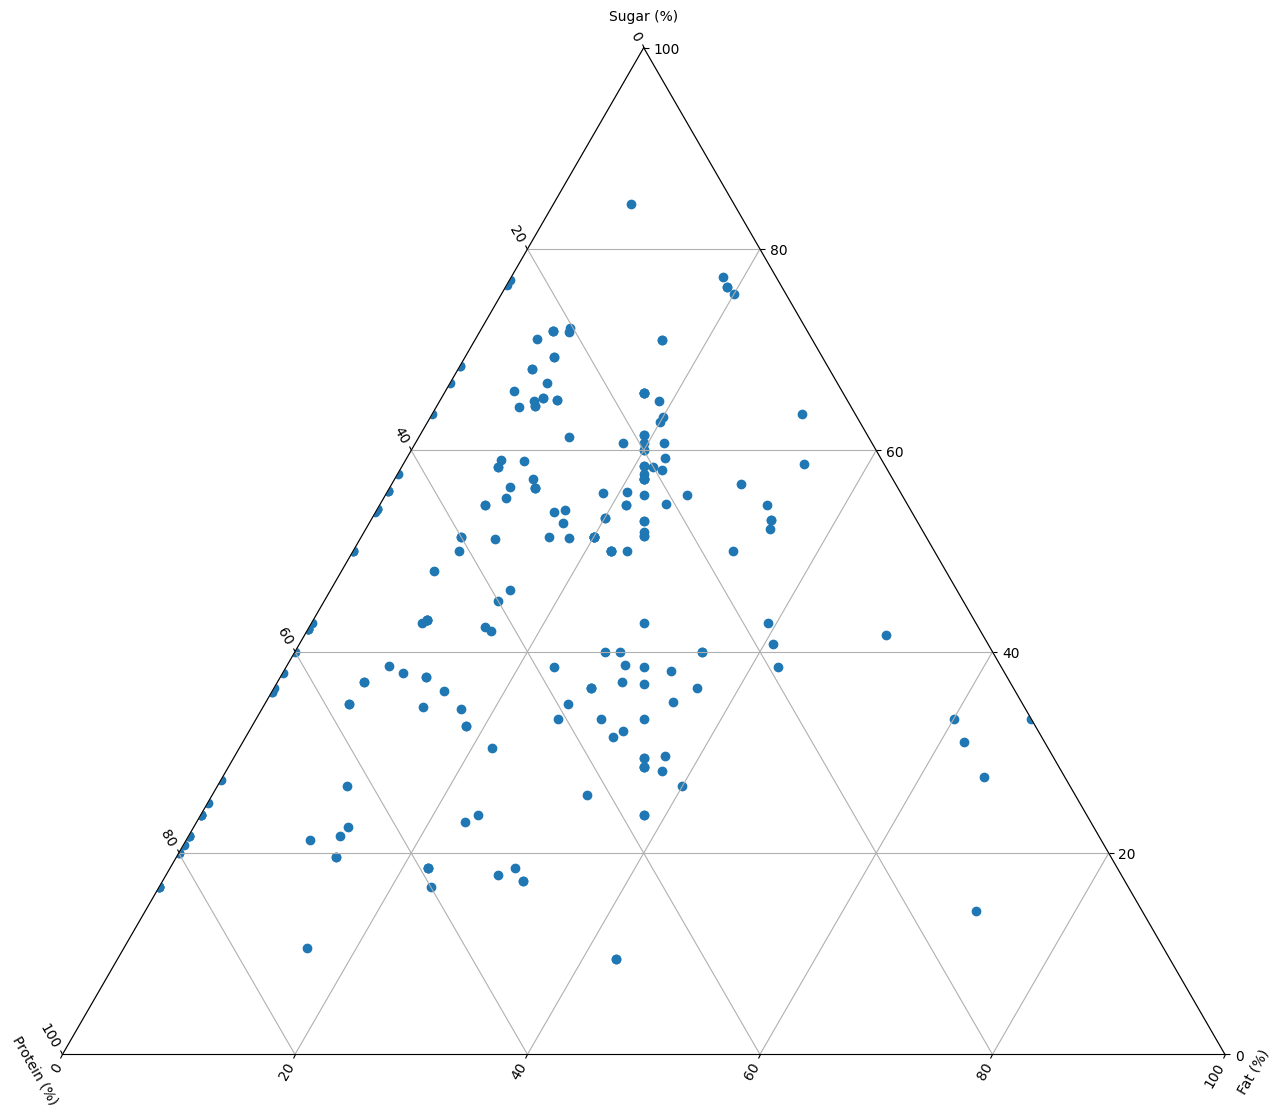

In [43]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)
# ax.set_title('Nutritional Profile of Yogurts at Whole Foods')
ax.set_tlabel("Sugar (%)")
ax.set_llabel("Protein (%)")
ax.set_rlabel("Fat (%)")
ax.grid()

pc = ax.scatter(parsed_df["SPF_Sugar_Pct"], parsed_df["SPF_Protein_Pct"], parsed_df["SPF_TotalFat_Pct"])

fig.savefig("./figures/all.svg", transparent=True)
fig.savefig("./figures/all.png", transparent=True)

plt.show()

# Plotting Yogurts based on Names

### Identifying Most Common Descriptors

In [44]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [45]:
nltk.download('punkt')
parsed_df["tokens"] = parsed_df["name"].apply(word_tokenize)

fdist = FreqDist()
for t in parsed_df["tokens"]:
    for w in t:
        fdist[w.lower()] += 1

# fdist.most_common(100)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stephanieandrews/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
parsed_df = parsed_df.assign(
    # fat-related
    cont_whole=lambda x: x["name"].str.contains("whole", case=False),
    cont_fat=lambda x: x["name"].str.contains("fat", case=False),
    cont_lowfat=lambda x: x["name"].str.contains("lowfat", case=False),    
    cont_nonfat=lambda x: x["name"].str.contains("non.*fat", case=False),
    cont_cream=lambda x: x["name"].str.contains("cream", case=False),
    # ethnic
    cont_yoghurt=lambda x: x["name"].str.contains("yoghurt", case=False),
    cont_icelandic=lambda x: x["name"].str.contains("icelandic", case=False),
    cont_aussie=lambda x: x["name"].str.contains("aussie", case=False),
    cont_greek=lambda x: x["name"].str.contains("greek", case=False),
    cont_kefir=lambda x: x["name"].str.contains("kefir", case=False),
    # alternative
    cont_alternative=lambda x: x["name"].str.contains("alternative", case=False),
    cont_vegan=lambda x: x["name"].str.contains("vegan", case=False),
    cont_nongmo=lambda x: x["name"].str.contains("non-gmo", case=False),
    cont_artisan=lambda x: x["name"].str.contains("artisan", case=False),
    cont_plantbased=lambda x: x["name"].str.contains("plant-based", case=False),
    cont_coconut = lambda x: x["name"].str.contains("coconut", case=False),
    cont_almond = lambda x: x["name"].str.contains("almond", case=False),
    cont_soy = lambda x: x["name"].str.contains("soy", case=False),
    cont_cashew = lambda x: x["name"].str.contains("cashew", case=False),
    # misc
    cont_organic=lambda x: x["name"].str.contains("organic", case=False),
    cont_probiotic=lambda x: x["name"].str.contains("probiotic", case=False),
    cont_plain=lambda x: x["name"].str.contains("plain", case=False),
    cont_milk=lambda x: x["name"].str.contains("milk", case=False),
    cont_drinkable=lambda x: x["name"].str.contains("drinkable", case=False),
    cont_kids=lambda x: x["name"].str.contains("kids", case=False),
    cont_protein=lambda x: x["name"].str.contains("protein", case=False),
    cont_unsweetened=lambda x: x["name"].str.contains("unsweetened", case=False),
    # is probiotic, based on ingredients list
    is_probiotic = lambda x: x["ingredients"].fillna("").apply(
        lambda x: " ".join(x)).str.contains("culture|probiotic", case=False)
)

### Greek, Icelandic, Protein Yogurts

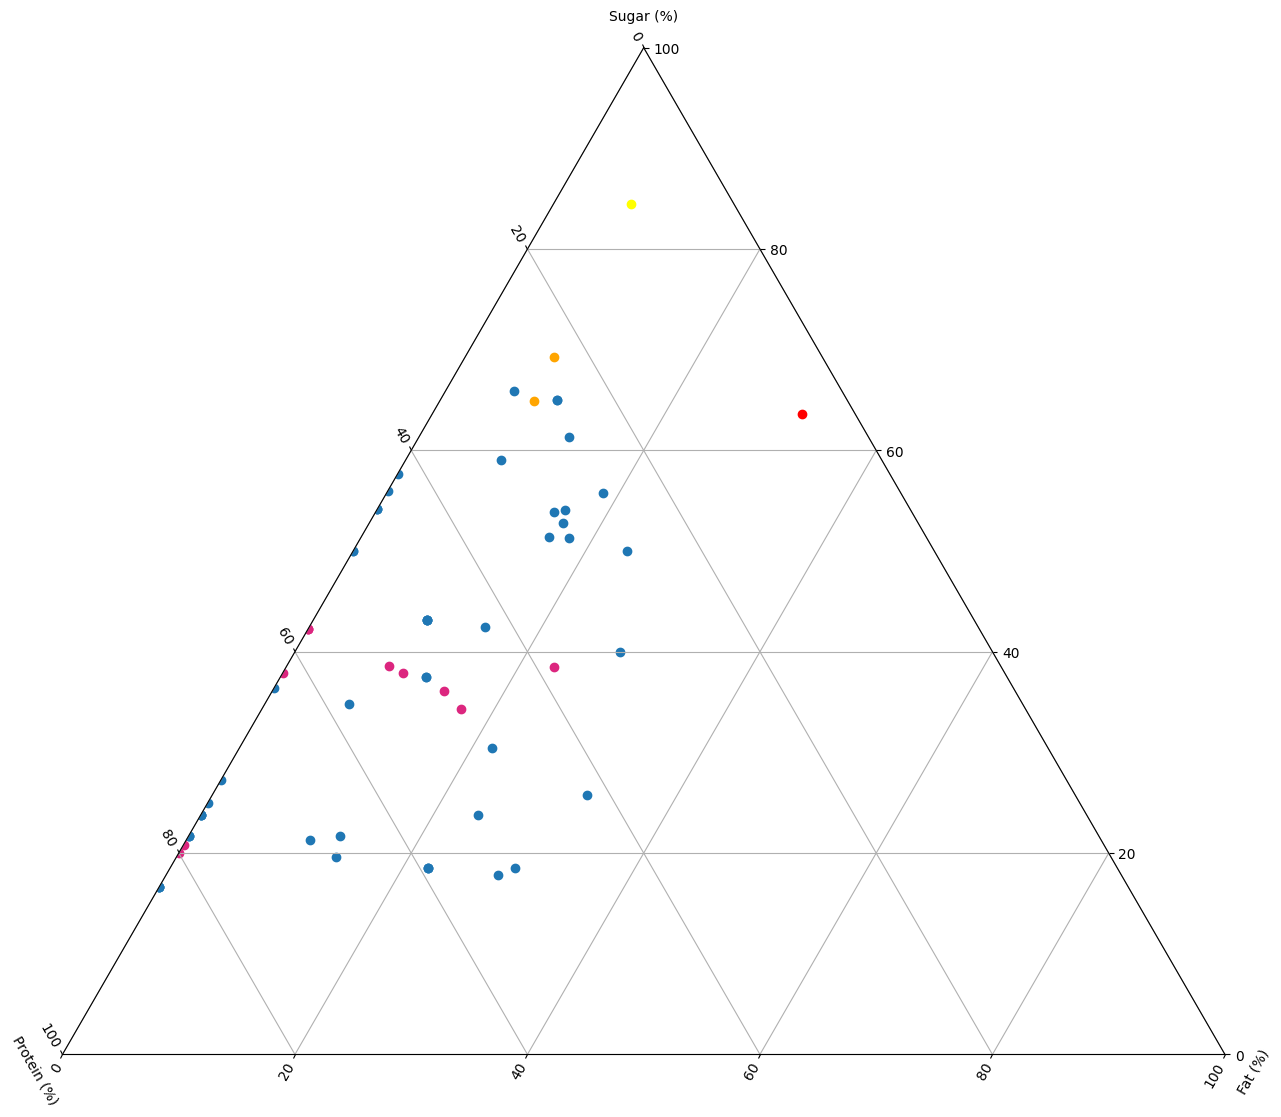

In [47]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)
ax.set_tlabel("Sugar (%)")
ax.set_llabel("Protein (%)")
ax.set_rlabel("Fat (%)")
ax.grid()

pc = ax.scatter(parsed_df[parsed_df["cont_protein"]==True]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["cont_protein"]==True]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["cont_protein"]==True]["SPF_TotalFat_Pct"],
                color="orange")
pc = ax.scatter(parsed_df[parsed_df["cont_greek"]==True]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["cont_greek"]==True]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["cont_greek"]==True]["SPF_TotalFat_Pct"])
pc = ax.scatter(parsed_df[parsed_df["cont_icelandic"]==True]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["cont_icelandic"]==True]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["cont_icelandic"]==True]["SPF_TotalFat_Pct"],
                color="#DC267F")

# plotting reference foods
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_TotalFat_Pct"],
                color="red")
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_TotalFat_Pct"],
                color="yellow")


plt.savefig("./figures/protein_greek_icelandic.svg")
plt.savefig("./figures/protein_greek_icelandic.png")
plt.show()

### Low-Fat and Non-Fat Yogurts

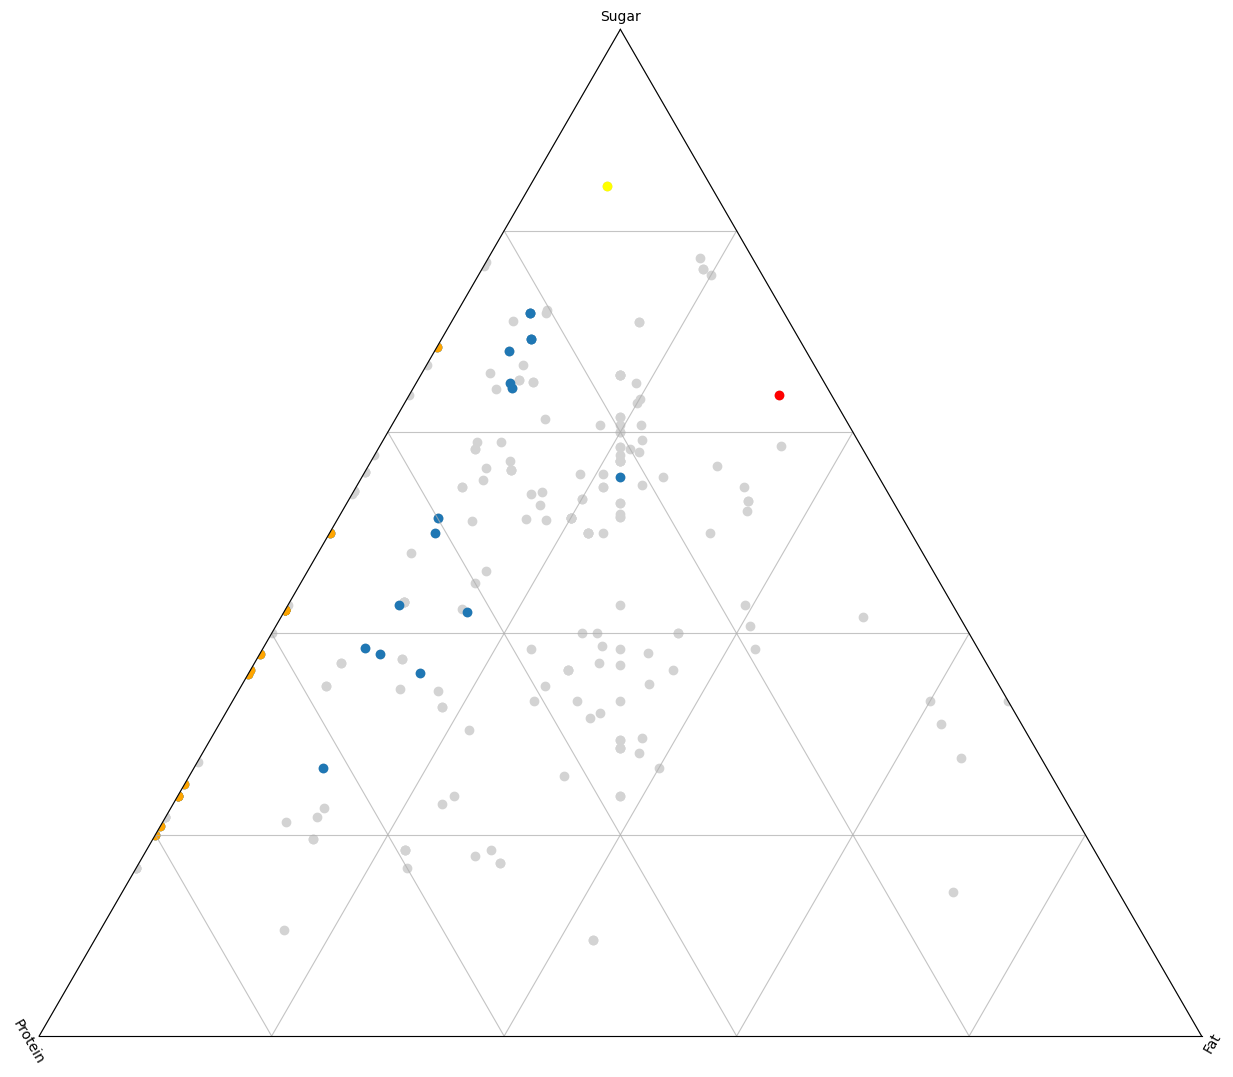

In [48]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)
ax.set_tlabel("Sugar")
ax.set_llabel("Protein")
ax.set_rlabel("Fat")
ax.grid()
ax.tick_params(grid_alpha=0.75, labelbottom=False, bottom=False)
pc = ax.scatter(parsed_df["SPF_Sugar_Pct"], parsed_df["SPF_Protein_Pct"], parsed_df["SPF_TotalFat_Pct"],
               color="lightgray")

pc = ax.scatter(parsed_df[(parsed_df["cont_lowfat"]==True) | (parsed_df["cont_nonfat"]==True)]["SPF_Sugar_Pct"], 
                parsed_df[(parsed_df["cont_lowfat"]==True) | (parsed_df["cont_nonfat"]==True)]["SPF_Protein_Pct"], 
                parsed_df[(parsed_df["cont_lowfat"]==True) | (parsed_df["cont_nonfat"]==True)]["SPF_TotalFat_Pct"], 
                color="#1f77b4")
pc = ax.scatter(parsed_df[parsed_df["cont_nonfat"]==True]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["cont_nonfat"]==True]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["cont_nonfat"]==True]["SPF_TotalFat_Pct"],
                color="orange")

# plotting reference foods
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_TotalFat_Pct"],
                color="red")
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_TotalFat_Pct"],
                color="yellow")


plt.savefig("./figures/lowfat_nonfat.svg")
plt.savefig("./figures/lowfat_nonfat.png")

plt.show()

### Probiotic Yogurts

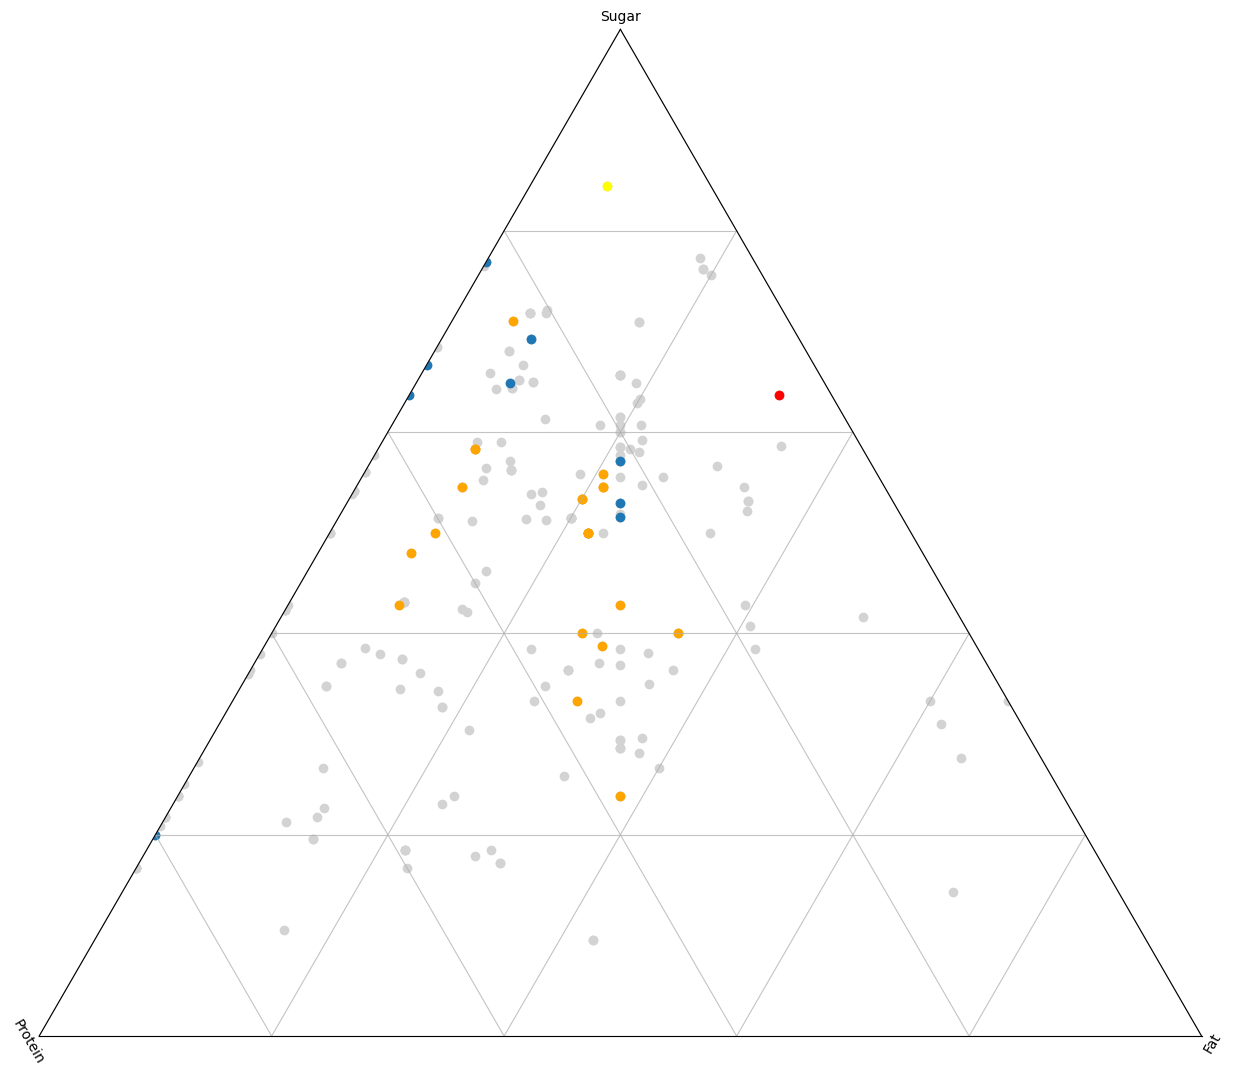

In [49]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)
ax.set_tlabel("Sugar")
ax.set_llabel("Protein")
ax.set_rlabel("Fat")
ax.grid()
ax.tick_params(grid_alpha=0.75, labelbottom=False, bottom=False)
pc = ax.scatter(parsed_df["SPF_Sugar_Pct"], parsed_df["SPF_Protein_Pct"], parsed_df["SPF_TotalFat_Pct"],
               color="lightgray")

pc = ax.scatter(parsed_df[(parsed_df["cont_probiotic"]==True)]["SPF_Sugar_Pct"], 
                parsed_df[(parsed_df["cont_probiotic"]==True)]["SPF_Protein_Pct"], 
                parsed_df[(parsed_df["cont_probiotic"]==True)]["SPF_TotalFat_Pct"], 
                color="#1f77b4") # blue
pc = ax.scatter(parsed_df[parsed_df["cont_kefir"]==True]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["cont_kefir"]==True]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["cont_kefir"]==True]["SPF_TotalFat_Pct"],
                color="orange")

# plotting reference foods
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_TotalFat_Pct"],
                color="red")
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_TotalFat_Pct"],
                color="yellow")

plt.savefig("./figures/probiotic_kefir.svg")
plt.savefig("./figures/probiotic_kefir.png")

plt.show()

In [50]:
# TODO: plot based on number of probiotic strains???

### Plant-Based Yogurts

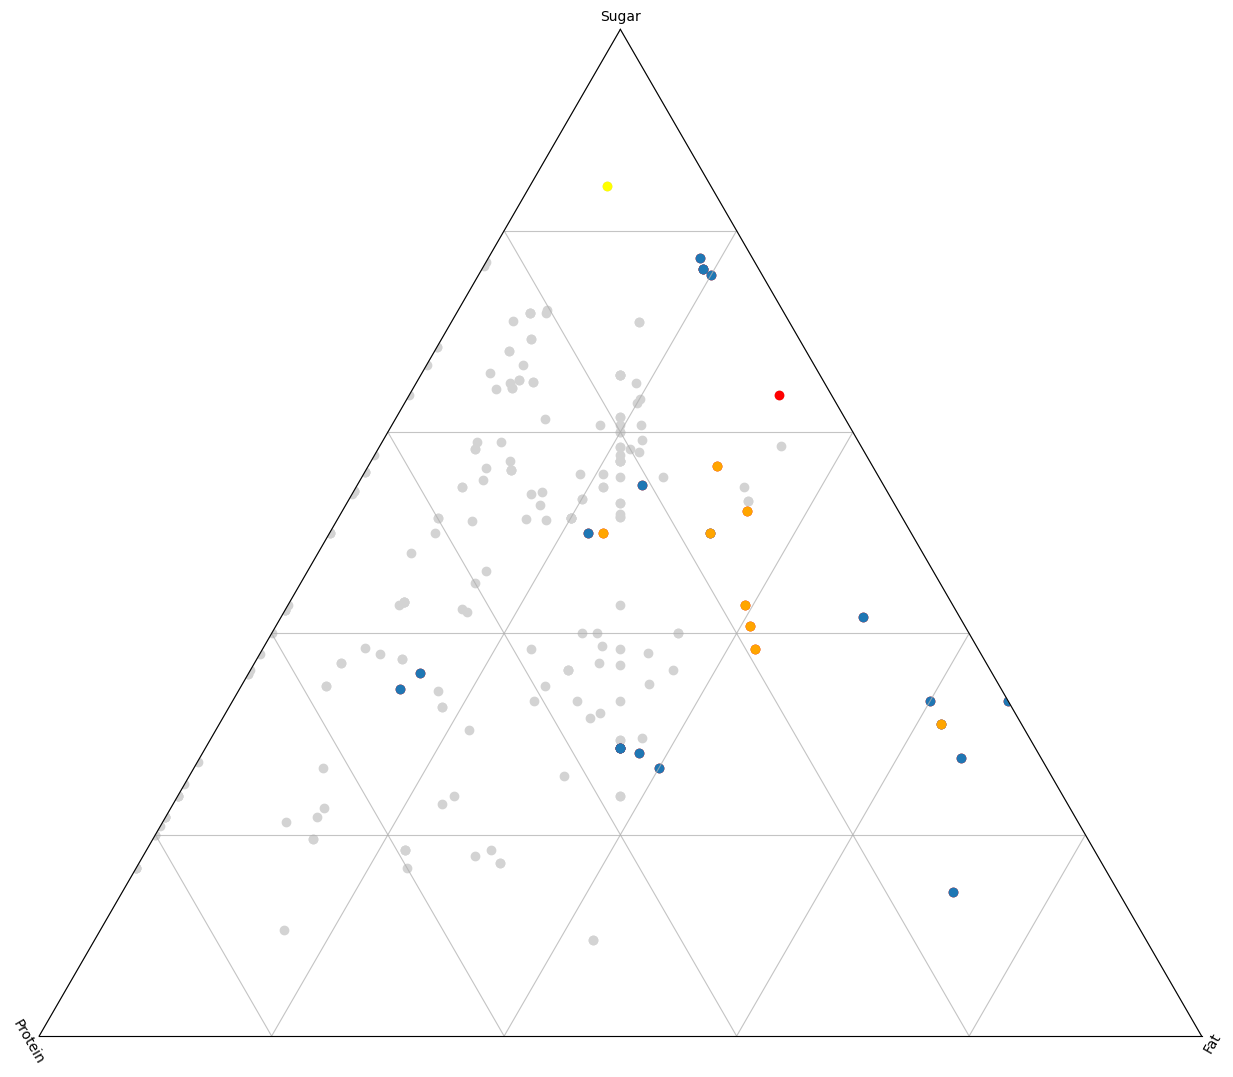

In [51]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)
ax.set_tlabel("Sugar")
ax.set_llabel("Protein")
ax.set_rlabel("Fat")
ax.grid()
ax.tick_params(grid_alpha=0.75, labelbottom=False, bottom=False)
pc = ax.scatter(parsed_df["SPF_Sugar_Pct"], parsed_df["SPF_Protein_Pct"], parsed_df["SPF_TotalFat_Pct"],
               color="lightgray")

pc = ax.scatter(parsed_df[(parsed_df["cont_vegan"]==True) | (parsed_df["cont_plantbased"]==True) | (parsed_df["cont_alternative"]) | (parsed_df["cont_coconut"]==True) | (parsed_df["cont_almond"]==True) | (parsed_df["cont_soy"])]["SPF_Sugar_Pct"], 
                parsed_df[(parsed_df["cont_vegan"]==True) | (parsed_df["cont_plantbased"]==True) | (parsed_df["cont_alternative"]) | (parsed_df["cont_coconut"]==True) | (parsed_df["cont_almond"]==True) | (parsed_df["cont_soy"])]["SPF_Protein_Pct"], 
                parsed_df[(parsed_df["cont_vegan"]==True) | (parsed_df["cont_plantbased"]==True) | (parsed_df["cont_alternative"]) | (parsed_df["cont_coconut"]==True) | (parsed_df["cont_almond"]==True) | (parsed_df["cont_soy"])]["SPF_TotalFat_Pct"], 
                color="red")
pc = ax.scatter(parsed_df[(parsed_df["cont_coconut"]==True)]["SPF_Sugar_Pct"], 
                parsed_df[(parsed_df["cont_coconut"]==True)]["SPF_Protein_Pct"], 
                parsed_df[(parsed_df["cont_coconut"]==True)]["SPF_TotalFat_Pct"], 
                color="#1f77b4") # blue
pc = ax.scatter(parsed_df[(parsed_df["cont_almond"]==True)]["SPF_Sugar_Pct"], 
                parsed_df[(parsed_df["cont_almond"]==True)]["SPF_Protein_Pct"], 
                parsed_df[(parsed_df["cont_almond"]==True)]["SPF_TotalFat_Pct"], 
                color="orange")

# plotting reference foods
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_TotalFat_Pct"],
                color="red")
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_TotalFat_Pct"],
                color="yellow")

plt.savefig("./figures/plantbased.svg")
plt.savefig("./figures/plantbased.png")

plt.show()


### Kids, Organic Yogurts

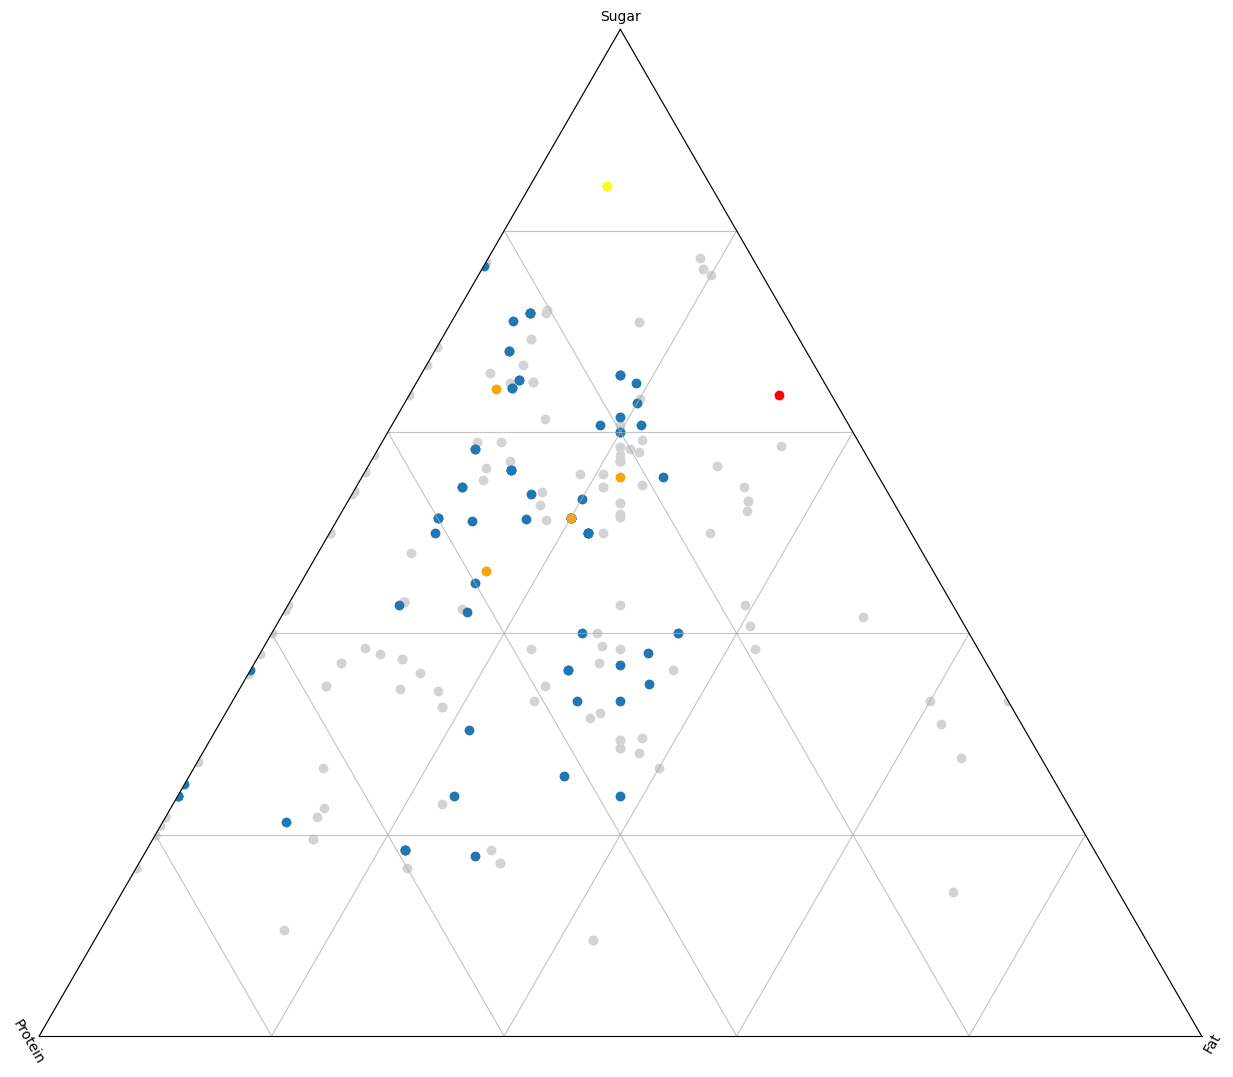

In [52]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

# fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)
# ax = fig.add_subplot(1, 2, 1, projection="ternary", ternary_sum=100.0)

ax.set_tlabel("Sugar")
ax.set_llabel("Protein")
ax.set_rlabel("Fat")
ax.grid()
ax.tick_params(grid_alpha=0.75, labelbottom=False, bottom=False)
pc = ax.scatter(parsed_df["SPF_Sugar_Pct"], parsed_df["SPF_Protein_Pct"], parsed_df["SPF_TotalFat_Pct"],
               color="lightgray")

pc = ax.scatter(parsed_df[parsed_df["cont_organic"]==True]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["cont_organic"]==True]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["cont_organic"]==True]["SPF_TotalFat_Pct"],
                color="#1f77b4")

pc = ax.scatter(parsed_df[parsed_df["cont_kids"]==True]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["cont_kids"]==True]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["cont_kids"]==True]["SPF_TotalFat_Pct"],
                color="orange")

# plotting reference foods
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("oreo", case=False)]["SPF_TotalFat_Pct"],
                color="red")
pc = ax.scatter(parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Sugar_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_Protein_Pct"], 
                parsed_df[parsed_df["name"].str.contains("pudding", case=False)]["SPF_TotalFat_Pct"],
                color="yellow")

plt.savefig("./figures/kids_organic.svg")
plt.savefig("./figures/kids_organic.png")

plt.show()

# Prepping table for Datawrapper

In [53]:
parsed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 80 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   link                      234 non-null    object 
 1   name                      234 non-null    object 
 2   brand                     234 non-null    object 
 3   diets                     232 non-null    object 
 4   categories                232 non-null    object 
 5   images                    232 non-null    object 
 6   ingredients               232 non-null    object 
 7   nutritionElements         232 non-null    object 
 8   servingInfo               232 non-null    object 
 9   servingSize               234 non-null    float64
 10  secondaryServingSize      234 non-null    float64
 11  servingSizeUom            234 non-null    object 
 12  secondaryServingSizeUom   232 non-null    object 
 13  Vitamin D                 217 non-null    float64
 14  Trans Fat 

In [54]:
# colors for image map
label_colors = ["magenta", "cyan", "yellow"]
parsed_df['color_label'] = parsed_df[['SPF_Sugar_Pct', 'SPF_Protein_Pct', 'SPF_TotalFat_Pct']].apply(
    lambda x: label_colors[np.argmax(x)], axis=1)

In [55]:
# parsing name to remove quantities
parsed_df["parsed_name"] = parsed_df.apply(
    lambda x: ",".join(x["name"].split(",")[:-1]) if "," in x["name"] else x["name"], axis=1)

# links for table
parsed_df["href"] = parsed_df.apply(lambda x: (f"<a href={x['link']}>{x['brand']} {x['parsed_name']}</a>"), axis=1)
parsed_df["href_2"] = parsed_df.apply(lambda x: (f"<a href={x['link']}>{x['parsed_name']}</a>"), axis=1)

In [56]:
# images
parsed_df["first_image"] = parsed_df["images"].fillna("").apply(lambda x: None if not bool(x) else x[0]["image"])
parsed_df["html_image"] = parsed_df['first_image'].apply(lambda x: f"<img src='{x}' width='100%'>" if bool(x) else None)

In [57]:
parsed_df["html_image"].head()

0    <img src='https://m.media-amazon.com/images/S/...
1    <img src='https://m.media-amazon.com/images/S/...
2    <img src='https://m.media-amazon.com/images/S/...
3    <img src='https://m.media-amazon.com/images/S/...
4    <img src='https://m.media-amazon.com/images/S/...
Name: html_image, dtype: object

In [58]:
# columns to export
export_df = parsed_df[[
    "href", "href_2", "html_image",
    "brand", "color_label",
    "Sugars", 'SPF_Sugar_Pct', 
    "Protein", 'SPF_Protein_Pct', 
    "Total Fat", 'SPF_TotalFat_Pct']]

In [59]:
export_df.to_csv("wf_yog_table_3.csv")

# Misc Data Exploration

In [60]:
parsed_df[parsed_df["SPF_Sugar_Pct"] > 50][["name", "Sugars", "Protein", "Total Fat", "SPF_Sugar_Pct", "SPF_Protein_Pct", "SPF_TotalFat_Pct"]] \
    .sort_values(by="SPF_Sugar_Pct", ascending=False).head(20)

,name,Sugars,Protein,Total Fat,SPF_Sugar_Pct,SPF_Protein_Pct,SPF_TotalFat_Pct
232,Original Chocolate Pudding Cups,19.0,2.0,1.5,84.444444,8.888889,6.666667
102,"Coconut Milk Yogurt Alternative, Strawberry Ba...",17.0,1.0,4.0,77.272727,4.545455,18.181818
77,"Strawberry Dairy Probiotic, 21 fl oz",10.0,3.0,0.0,76.923077,23.076923,0.000000
175,"Organic Strawberry French Style Yogurt, 4.75 oz",13.0,4.0,0.0,76.470588,23.529412,0.000000
110,"Dairy Free Coconut Milk Yogurt Alternative, Ke...",16.0,1.0,4.0,76.190476,4.761905,19.047619
84,"Coconut Milk Yogurt Alternative, Peach, Vegan,...",16.0,1.0,4.0,76.190476,4.761905,19.047619
122,"Coconut Milk Yogurt Alternative, Chocolate, Ve...",17.0,1.0,4.5,75.555556,4.444444,20.000000
166,"Yogurtz Banana, 12 oz",57.0,16.0,6.0,72.151899,20.253165,7.594937
174,Organic Lowfat Peach Yogurt,23.0,7.0,2.0,71.875000,21.875000,6.250000
180,Organic Low Fat Blueberry Yogurt,23.0,7.0,2.0,71.875000,21.875000,6.250000


In [61]:
parsed_df[parsed_df["SPF_Protein_Pct"] > 50][["name", "Sugars", "Protein", "Total Fat", "SPF_Sugar_Pct", "SPF_Protein_Pct", "SPF_TotalFat_Pct"]] \
    .sort_values(by="SPF_Protein_Pct", ascending=False).head(20)

,name,Sugars,Protein,Total Fat,SPF_Sugar_Pct,SPF_Protein_Pct,SPF_TotalFat_Pct
165,"Chocolate Drinkable Greek Yogurt, 32 fl oz",3.0,15.0,0.0,16.666667,83.333333,0.000000
164,"Chocolate Drinkable Greek Yogurt, 32 fl oz",3.0,15.0,0.0,16.666667,83.333333,0.000000
152,"Drinkable Greek Yogurt Strwbrry Banana, 12 fl oz",4.0,20.0,0.0,16.666667,83.333333,0.000000
137,"Mixed Berry Greek Drinkabe Yogurt, 32 fl oz",3.0,15.0,0.0,16.666667,83.333333,0.000000
198,"siggi’s® Icelandic Skyr Nonfat Yogurt, Plain, ...",4.0,16.0,0.0,20.000000,80.000000,0.000000
143,"Original Fermented Dairy Probiotic, 12 pk, 42 ...",1.0,4.0,0.0,20.000000,80.000000,0.000000
6,"siggi’s® Icelandic Skyr Nonfat Yogurt, Plain, ...",5.0,19.0,0.0,20.833333,79.166667,0.000000
226,Total Plain 0% 32 oz,5.0,18.0,0.0,21.739130,78.260870,0.000000
154,"Peach Drinkable Greek Yogurt, 12 fl oz",5.0,18.0,0.0,21.739130,78.260870,0.000000
11,"Total 0% Plain Greek Yogurt, 16 oz",5.0,18.0,0.0,21.739130,78.260870,0.000000


In [62]:
parsed_df[parsed_df["SPF_TotalFat_Pct"] > 50][["name", "Sugars", "Protein", "Total Fat", "SPF_Sugar_Pct", "SPF_Protein_Pct", "SPF_TotalFat_Pct"]] \
    .sort_values(by="SPF_TotalFat_Pct", ascending=False).head(20)

,name,Sugars,Protein,Total Fat,SPF_Sugar_Pct,SPF_Protein_Pct,SPF_TotalFat_Pct
13,"Dairy Free Coconut Milk Yogurt Alternative, Un...",1.0,1.0,5.0,14.285714,14.285714,71.428571
163,"Chocolate Mousse Coconut Yogurt, 8 fl oz",3.0,0.0,6.0,33.333333,0.000000,66.666667
79,"Coconut Yogurt Blueberry Lavender, 5 oz",8.0,2.0,19.0,27.586207,6.896552,65.517241
112,"Sour Cherry Almond Coconut Yogurt, 5 oz",9.0,2.0,18.0,31.034483,6.896552,62.068966
190,"Coconut Yogurt, 5 oz",10.0,2.0,18.0,33.333333,6.666667,60.000000


In [63]:
parsed_df[parsed_df['name'].str.contains('coconut', case=False)][['name', 'standard_fats', 'SPF_TotalFat_Pct']] \
    .sort_values(by='SPF_TotalFat_Pct', ascending=False)

,name,standard_fats,SPF_TotalFat_Pct
13,"Dairy Free Coconut Milk Yogurt Alternative, Un...",5.000000,71.428571
163,"Chocolate Mousse Coconut Yogurt, 8 fl oz",40.800000,66.666667
79,"Coconut Yogurt Blueberry Lavender, 5 oz",22.746479,65.517241
112,"Sour Cherry Almond Coconut Yogurt, 5 oz",21.549296,62.068966
190,"Coconut Yogurt, 5 oz",21.549296,60.000000
159,"Unsweetened Coconut Yogurt Drink, 24 fl oz",4.250000,50.000000
108,"siggi’s® Plant-Based Coconut Blend, Toasted Co...",13.600000,40.000000
64,"siggi’s® Plant-Based Coconut Blend, Vanilla, 2...",12.000000,37.500000
99,Raspberry (5.3oz) Plant Based Coconut Blend,11.333333,35.714286
56,Mixed Berries (5.3oz) Plant Based Coconut Blend,11.333333,35.714286


# In-Progress Analysis

In [64]:
ingredient_filler_strings = [
    "Our Family Recipe:", "Our Recipe:",
    "Ingredients:", "Ingerdients:", 
    "Our Strawberry Vanilla Recipe:", "Our Blueberry Recipe:",
    "and"]

cultures_regex = r"(Cultures.*|Probiotic.*|Active.+Culture.*|Liv.+Culture.*)"
parsed_df["stripped_ingred"] = parsed_df["ingredients"].apply(
    lambda x: re.sub(r'|'.join(map(re.escape, ingredient_filler_strings)), '', "".join(x)).strip()
)
parsed_df["cultures"] = parsed_df["stripped_ingred"].str.extract(cultures_regex)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/stephanieandrews/.pyenv/versions/3.10.11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gv/0v94vhz11wd17twvmg0qj8rc0000gn/T/ipykernel_20756/4110798778.py", line 8, in <module>
    parsed_df["stripped_ingred"] = parsed_df["ingredients"].apply(
  File "/Users/stephanieandrews/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pandas/core/series.py", line 4630, in apply
    return SeriesApply(self, func, convert_dtype, args, kwargs).apply()
  File "/Users/stephanieandrews/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pandas/core/apply.py", line 1025, in apply
    return self.apply_standard()
  File "/Users/stephanieandrews/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pandas/core/apply.py", line 1076, in apply_standard
    mapped = lib.map_infer(
  File "pandas/_libs/lib.pyx", line 2834, in pandas._libs.lib.map